In [13]:
random_state = 42

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

In [14]:
train = pd.read_csv("../data/pre_train3.csv")
test = pd.read_csv("../data/pre_test3.csv")
y = pd.read_csv("../data/target3.csv")

/opt/conda/envs/ml_1/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/opt/conda/envs/ml_1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/conda/envs/ml_1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


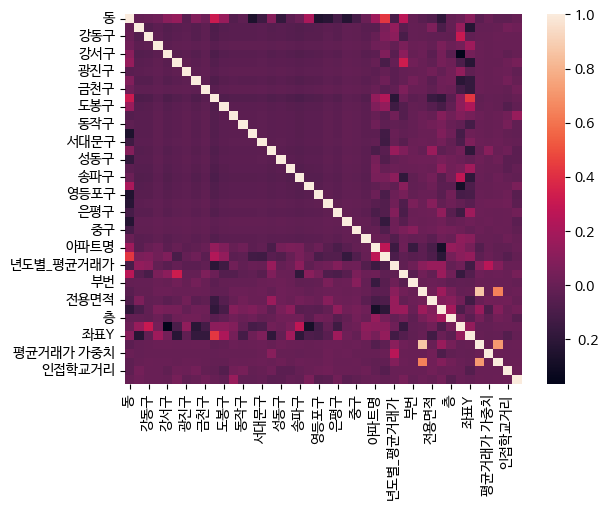

In [15]:
sns.heatmap(train.corr())

In [16]:
corr = train.corr()

In [17]:
# unecessary_var =['본번', '도로명', '동', '부번'
#                  ]

unecessary_var =[
                #  '강남구',
                #  '송파구',
                 '서초구',
                 '동작구',
                 '양천구',
                 '성동구',
                 '마포구',
                 '서대문구',
                 '용산구',
                 '광진구',
                 '강서구',
                 '도봉구',
                 '은평구',
                 '구로구',
                 '강동구',
                 '영등포구',
                 '성북구',
                 '동대문구',
                 '중랑구',
                 '강북구',
                 '노원구',
                 '금천구',
                 '관악구',
                 '종로구',
                 '중구',
                 '평균거래가 가중치2',
                 '평균거래가 가중치'
                 ]



for col in unecessary_var:
    train.drop(col, axis=1, inplace=True)
    test.drop(col, axis=1, inplace=True)

In [18]:
train.columns

Index(['동', '강남구', '송파구', '아파트명', '도로명', '년도별_평균거래가', '본번', '부번', '계약년월일',
       '전용면적', '건축년도', '층', '좌표X', '좌표Y', '계약년도별_평균거래가', '인접학교거리', '인접지하철거리'],
      dtype='object')

In [19]:
# train['년도별_평균거래가'] = np.log1p(train['년도별_평균거래가'])
# test['년도별_평균거래가'] = np.log1p(test['년도별_평균거래가'])

# train['계약년도별_평균거래가'] = np.log1p(train['계약년도별_평균거래가'])
# test['계약년도별_평균거래가'] = np.log1p(test['계약년도별_평균거래가'])

In [20]:
# 계약년월일 나누기 
def slicing_year_month(df):
    df["계약년월일"] = df["계약년월일"].astype(str)

    df["계약년"] = df["계약년월일"].str[:4].astype(int)
    df["계약월"] = df["계약년월일"].str[4:6].astype(int)

    df.drop(columns="계약년월일", inplace=True)
    return df


train = slicing_year_month(train)
test = slicing_year_month(test)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=random_state)

In [22]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)

In [23]:
model = RandomForestRegressor(n_estimators=10, criterion='squared_error', random_state=random_state, n_jobs=-1)
model.fit(x_train, y_train)

/tmp/ipykernel_901504/1461777480.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [24]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE train: {np.sqrt(metrics.mean_squared_error(y_train, pred_train))}')
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_test, pred_test))}')

RMSE train: 0.03967428908850535
RMSE test: 0.0912945009169785


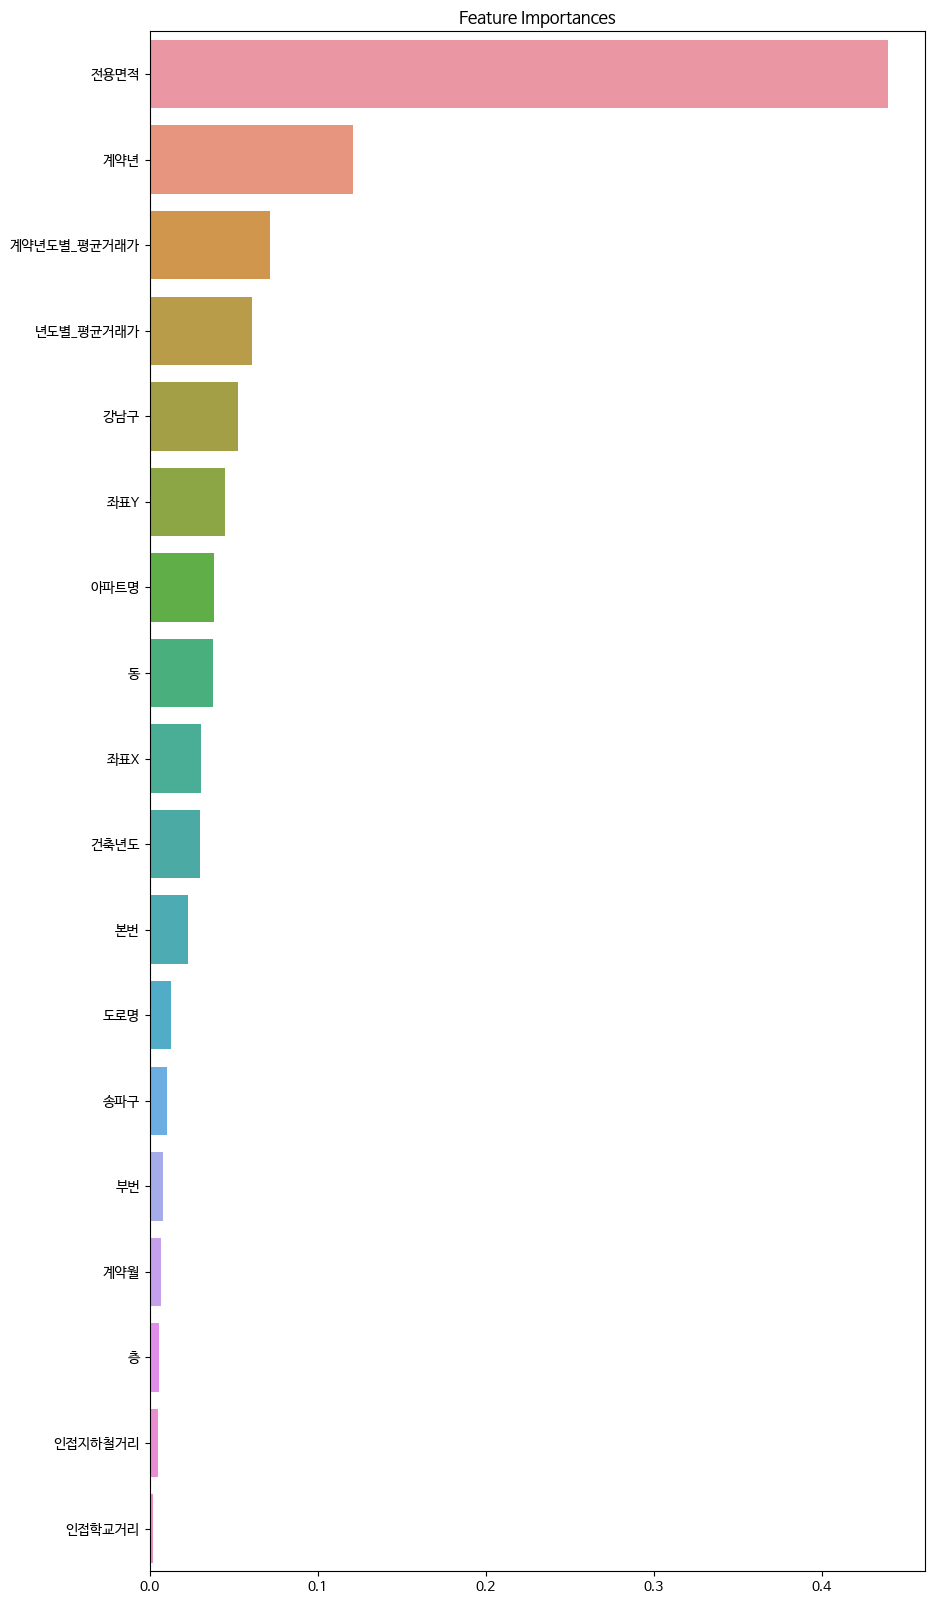

In [25]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(x_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,20))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [ ]:
# Training API에서는 Parameter를 별도의 Dictionary 형태로 입력을 받습니다.
# 간단한 실습을 위해, 가장 기본적인 Parameter들을 사용합니다.

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': 1,
    'random_state': random_state
}

eval_result = {}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=150000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['training', 'validation'],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=10),
        lgb.record_evaluation(eval_result)
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 783122, number of used features: 18
[LightGBM] [Info] Start training from score 10.751042
Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 0.60065	validation's rmse: 0.600025
[20]	training's rmse: 0.565082	validation's rmse: 0.564418
[30]	training's rmse: 0.53648	validation's rmse: 0.535867
[40]	training's rmse: 0.507287	validation's rmse: 0.506647
[50]	training's rmse: 0.482784	validation's rmse: 0.482204
[60]	training's rmse: 0.459875	validation's rmse: 0.459336
[70]	training's rmse: 0.438298	validation's rmse: 0.437762
[80]	training's rmse: 0.418777	validation's rmse: 0.418274
[90]	training's rmse: 0.401803	validation's rmse: 0.401348
[

In [11]:
gbm.best_iteration

29530

## 모델결과 후처리

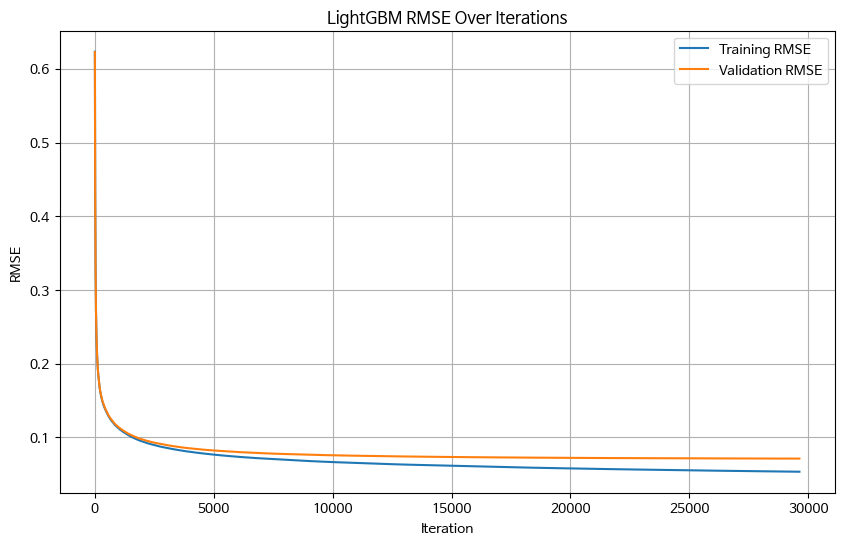

In [12]:
rmse_train = eval_result['training']['rmse']
rmse_val = eval_result['validation']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(rmse_train, label='Training RMSE')
plt.plot(rmse_val, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('LightGBM RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

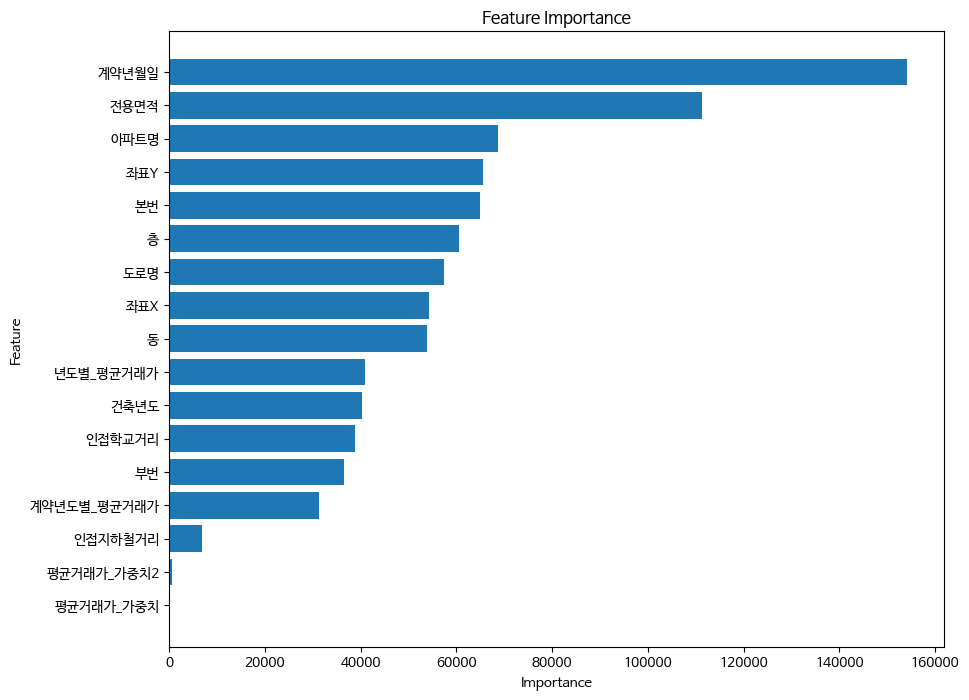

In [13]:
# gbm.feature_importance(importance_type='gain')
importances_trained = gbm.feature_importance(importance_type='split')
feature_names = gbm.feature_name()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_trained
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [15]:
import pickle

# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('../result/light_gbm-4_by3_para_del_saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [14]:
predicts = gbm.predict(test)
display(f"추론 결과 샘플 : {predicts[:4]}")
real_pred = np.expm1(predicts)
preds_df = pd.DataFrame(real_pred.astype(int), columns=["target"])
display(preds_df.info())

'추론 결과 샘플 : [12.16037078 12.54543082 12.69916378 12.54908135]'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  9272 non-null   int64
dtypes: int64(1)
memory usage: 72.6 KB


None

In [16]:
preds_df.to_csv('light_gbm-4_by3_para_del.csv', index=False)